In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.image_classification.models.squeezenext import SqueezeNeXt
from torchvision import transforms
from torchvision.datasets import GTSRB

# Setting

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

In [3]:
artifact_path = Path("../../artifacts/squeezenext")
data_path = Path("../../data/gtsrb")

In [4]:
device = torch.device("cuda:0")

# data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [6]:
train_dataset = GTSRB(
    data_path.as_posix(),
    split="train",
    transform=preprocess,
    download=True,
)

In [7]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [8]:
num_class = 43

In [9]:
len(train_dataset)

26640

38


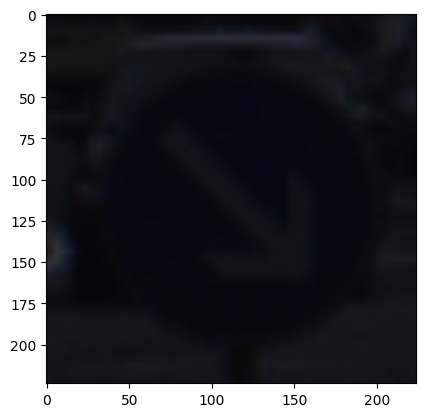

In [10]:
import random
from torchlake.common.utils.convert import img_tensor_to_np

demo_img, demo_label = random.choice(train_dataset)
print(demo_label)
plt.imshow((img_tensor_to_np(demo_img) * IMAGENET_STD + IMAGENET_MEAN).clip(0, 1))

# model

In [11]:
model = SqueezeNeXt(output_size=num_class, width_multiplier=1.0, version=4).to(device)

In [12]:
torchinfo.summary(model)

Layer (type:depth-idx)                                  Param #
SqueezeNeXt                                             --
├─Sequential: 1-1                                       --
│    └─Conv2dNormActivation: 2-1                        --
│    │    └─Conv2d: 3-1                                 4,864
│    │    └─ReLU: 3-2                                   --
│    └─MaxPool2d: 2-2                                   --
│    └─ResBlock: 2-3                                    --
│    │    └─ReLU: 3-3                                   --
│    │    └─BottleNeck: 3-4                             2,992
│    │    └─Conv2dNormActivation: 3-5                   2,112
│    └─ResBlock: 2-4                                    --
│    │    └─ReLU: 3-6                                   --
│    │    └─BottleNeck: 3-7                             2,480
│    │    └─Identity: 3-8                               --
│    └─ResBlock: 2-5                                    --
│    │    └─ReLU: 3-9                  

# training

In [13]:
epochs = 30
acc_iters = 256 // BATCH_SIZE

In [14]:
trainer = ClassificationTrainer(epochs, device, acc_iters)

In [15]:
criterion = trainer.get_criterion(num_class)
optim = torch.optim.Adam(model.parameters())

In [16]:
training_loss = trainer.run(train_loader, model, optim, criterion)

  0%|          | 0/416 [00:00<?, ?it/s]

100%|██████████| 416/416 [01:23<00:00,  4.99it/s]


epoch 1 : 0.013057440530526666


100%|██████████| 416/416 [01:12<00:00,  5.76it/s]


epoch 2 : 0.011812272777136128


100%|██████████| 416/416 [01:09<00:00,  5.95it/s]


epoch 3 : 0.009644898337473232


100%|██████████| 416/416 [01:09<00:00,  5.96it/s]


epoch 4 : 0.00651509102093629


100%|██████████| 416/416 [01:12<00:00,  5.76it/s]


epoch 5 : 0.004412878572251289


100%|██████████| 416/416 [01:10<00:00,  5.88it/s]


epoch 6 : 0.0030341275420281678


100%|██████████| 416/416 [01:12<00:00,  5.73it/s]


epoch 7 : 0.002202930809009838


100%|██████████| 416/416 [01:12<00:00,  5.73it/s]


epoch 8 : 0.0015642507420964718


100%|██████████| 416/416 [01:12<00:00,  5.77it/s]


epoch 9 : 0.001190454259253434


100%|██████████| 416/416 [01:14<00:00,  5.56it/s]


epoch 10 : 0.0009168183826729476


100%|██████████| 416/416 [01:11<00:00,  5.82it/s]


epoch 11 : 0.0007774157818403182


100%|██████████| 416/416 [01:11<00:00,  5.79it/s]


epoch 12 : 0.0006279586626498293


100%|██████████| 416/416 [01:10<00:00,  5.90it/s]


epoch 13 : 0.0005362410533437539


100%|██████████| 416/416 [01:11<00:00,  5.80it/s]


epoch 14 : 0.0004852648231078022


100%|██████████| 416/416 [01:11<00:00,  5.80it/s]


epoch 15 : 0.00040527500435088697


100%|██████████| 416/416 [01:13<00:00,  5.67it/s]


epoch 16 : 0.00038745942617004824


100%|██████████| 416/416 [01:11<00:00,  5.79it/s]


epoch 17 : 0.0003447008787921172


100%|██████████| 416/416 [01:16<00:00,  5.42it/s]


epoch 18 : 0.00032725749818714926


100%|██████████| 416/416 [01:14<00:00,  5.59it/s]


epoch 19 : 0.00025310054464765784


100%|██████████| 416/416 [01:23<00:00,  4.97it/s]


epoch 20 : 0.00029804757611355645


100%|██████████| 416/416 [01:14<00:00,  5.61it/s]


epoch 21 : 0.0002644395736935551


100%|██████████| 416/416 [01:15<00:00,  5.50it/s]


epoch 22 : 0.0002201932343705966


100%|██████████| 416/416 [01:11<00:00,  5.78it/s]


epoch 23 : 0.0002441722433777963


100%|██████████| 416/416 [01:21<00:00,  5.10it/s]


epoch 24 : 0.00021885365186755315


100%|██████████| 416/416 [01:24<00:00,  4.94it/s]


epoch 25 : 0.00021576684871040295


100%|██████████| 416/416 [01:13<00:00,  5.66it/s]


epoch 26 : 0.00019287712434080416


100%|██████████| 416/416 [01:11<00:00,  5.80it/s]


epoch 27 : 0.00017416448775538112


100%|██████████| 416/416 [01:11<00:00,  5.85it/s]


epoch 28 : 0.00017770421296439473


100%|██████████| 416/416 [01:14<00:00,  5.61it/s]


epoch 29 : 0.00015982730050723148


100%|██████████| 416/416 [01:12<00:00,  5.75it/s]

epoch 30 : 0.00020529915397232273


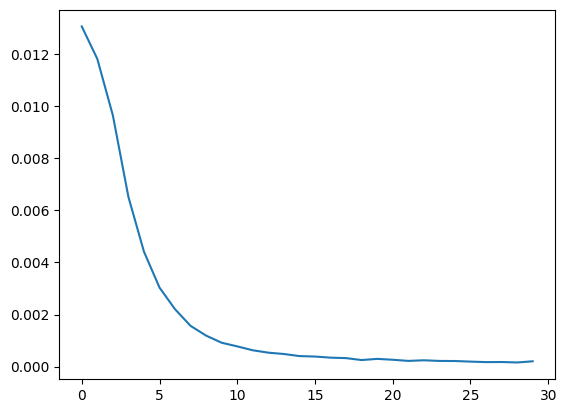

In [17]:
plt.plot(training_loss)

# inference

In [18]:
test_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [19]:
test_dataset = GTSRB(
    data_path.as_posix(),
    split="test",
    transform=test_preprocess,
    download=True,
)

In [20]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [21]:
evaluator = ClassificationEvaluator(num_class, device)

In [22]:
confusion_matrix = evaluator.run(test_loader, model)

100%|██████████| 198/198 [02:14<00:00,  1.47it/s]

[[ 19  33   3 ...   0   0   0]
 [ 24 614  56 ...   1   0   0]
 [  0  34 649 ...   0   0   0]
 ...
 [  0   0   0 ...  73   0   0]
 [  0   0   0 ...   0  31  13]
 [  0   2   0 ...   0   5  69]]


In [23]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(range(num_class), per_class_acc)

0         : 0.31666666666666665
1         : 0.8527777777777777
2         : 0.8653333333333333
3         : 0.7022222222222222
4         : 0.8303030303030303
5         : 0.7158730158730159
6         : 0.7533333333333333
7         : 0.7333333333333333
8         : 0.8377777777777777
9         : 0.9291666666666667
10        : 0.9757575757575757
11        : 0.8547619047619047
12        : 0.8594202898550725
13        : 0.9888888888888889
14        : 0.8814814814814815
15        : 0.6428571428571429
16        : 0.8666666666666667
17        : 0.8388888888888889
18        : 0.6410256410256411
19        : 0.75
20        : 0.2111111111111111
21        : 0.3888888888888889
22        : 0.9083333333333333
23        : 0.5066666666666667
24        : 0.4111111111111111
25        : 0.8979166666666667
26        : 0.8666666666666667
27        : 0.4166666666666667
28        : 0.6
29        : 0.7444444444444445
30        : 0.21333333333333335
31        : 0.7703703703703704
32        : 0.6
33        : 0.52857

In [24]:
per_class_acc.mean()

0.704586204932767

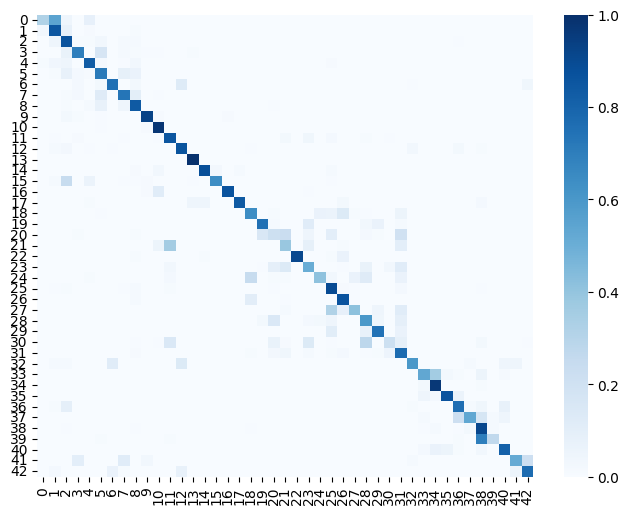

In [25]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    range(num_class),
    "Blues",
    annot=False,
    figsize=(8, 6),
)

In [26]:
model_path = artifact_path / f'squeezenext-{model.width_multiplier}-{model.num_layer}v{model.version}.pth'

In [27]:
torch.save(model.state_dict(), model_path)

In [28]:
get_file_size(model_path)

'2.64MB'

In [29]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>